In [1]:
import json
import numpy as np
import pandas as pd
from scipy.stats.stats import pearsonr 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

In [3]:
meta_path = '/Users/chrisiyer/_Current/thesis_folder/face_experiment/stimuli/metadata_all_pairs_mb_altered.json'

# read file
with open(meta_path, 'r') as myfile:
    data=myfile.read()

# parse file
meta = json.loads(data)

In [4]:
datapath = '/Users/chrisiyer/_Current/thesis_folder/face_experiment/results/data/classification/'
datafile = 'trialdata_faces_classification_task_02_04_2022.csv'
data = pd.read_csv(datapath+datafile)
data = data[(data.experiment_id != '9be974urmy8wojz5b1kn') & (data.experiment_id != 'px9sufzovs6fmvr1xfsj')] # my test runs

In [5]:
# want option of matching race, gender, facial hair
# pairs: model_similar, model_group, behavior_similar, behavior_group
# for now, just do behavior_similar
key_race = {
    'black': 0,
    'white': 1,
    'east_asian': 2,
    'south_asian': 3,
    'latinx': 4,
    'other': 5,
}
key_gender = {
    'woman': 0,
    'man': 1,
    'other': 2,
}
# backwards
key_race2 = {
    0: 'black',
    1: 'white',
    2: 'east_asian',
    3: 'south_asian',
    4: 'latinx',
    5: 'other',
}
key_gender2 = {
    0: 'woman',
    1: 'man',
    2: 'other',
}

In [6]:
info = {} # where I will store all my data
for item in meta.keys():
    info[item] = {
        'race_counts': [0,0,0,0,0,0],
        'gender_counts': [0,0,0],
        'facial_hair': meta[item]['facial_hair']
    }

In [7]:
# loop through data.
# loop through each race in response_race (excluding numbers) 
# and add response_race_sure to respective categories
# same with gender
for i in range(len(data)):
    
    curr_id = data.iloc[i]['stimulus'][2:5] # id
    
    for item in key_race.keys():
        if item in data.iloc[i]['response_race']:
            slider = data.iloc[i]['response_race_sure']
            if slider == 0: slider = 100
            info[curr_id]['race_counts'][key_race[item]] += slider 
#             info[curr_id]['race_counts'][key_race[item]] += 1
    
    for item in key_gender.keys():
        if item == 'man':
            # only add if 'wo' is not present before man
            resp = data.iloc[i]['response_gender']
            if item in resp and resp[resp.index('man')-2:resp.index('man')] != 'wo':# CAREFUL:'MAN' is in 'WOMAN'
                if slider == 0: slider = 100
                info[curr_id]['gender_counts'][key_gender[item]] += slider
                 #info[curr_id]['gender_counts'][key_gender[item]] += 1 
        else:
            # add just if the item is there
            if item in data.iloc[i]['response_gender']: # THIS IS THE ISSUE. 'MAN' is in 'WOMAN'
                if slider == 0: slider = 100
                info[curr_id]['gender_counts'][key_gender[item]] += slider
                 #info[curr_id]['gender_counts'][key_gender[item]] += 1 

In [8]:
# how many faces were white most of the time?
ans = [0,0,0,0,0,0] #black, white, east asian, south asian, latinx, other{
for k in info.keys():
    m = np.argmax(info[k]['race_counts'])
    ans[m] = ans[m]+1
ans

[56, 56, 2, 3, 39, 0]

In [9]:
# now I just want race and gender breakdown for black and white faces
wm = 0
ww = 0
bm = 0
bw = 0
wo = 0
bo = 0

for k in meta.keys():
    if meta[k]['race_common'] == 'black' and meta[k]['gender_common'] == 'woman': bw+=1
    if meta[k]['race_common'] == 'black' and meta[k]['gender_common'] == 'man': bm+=1
    if meta[k]['race_common'] == 'white' and meta[k]['gender_common'] == 'woman': ww+=1
    if meta[k]['race_common'] == 'white' and meta[k]['gender_common'] == 'man': wm+=1 
    if meta[k]['race_common'] == 'white' and meta[k]['gender_common'] == 'other': wo+=1  
    if meta[k]['race_common'] == 'black' and meta[k]['gender_common'] == 'other': bo+=1  

pd.DataFrame([bw,bm,ww,wm,wo,bo]) # other(s) = 0

,0
0,22
1,34
2,24
3,32
4,0
5,0


In [10]:
# no women are mismatched between my gender guess and classification judgements. but many are classified as men but guessed woman by me
wm = []
bm = []

for k in meta.keys():
    if meta[k]['race_common'] == 'black' and meta[k]['gender_common'] == 'man': 
        if meta[k]['gender_guess'] != 'm':
            bm.append(k)
    if meta[k]['race_common'] == 'white' and meta[k]['gender_common'] == 'man':
        if meta[k]['gender_guess'] != 'm':
            wm.append(k)
wm = [int(i) for i in wm]
wm.sort()
bm = [int(i) for i in bm]
bm.sort()
print('gender-mismatch identities white:', wm)
print('gender-mismatch identities black:', bm)


gender-mismatch identities white: []
gender-mismatch identities black: [36, 85, 124, 137]


In [11]:
# next: 1) do pairs of behavior_similar look plausible?
imstart = '/Users/chrisiyer/_Current/thesis_folder/face_experiment/stimuli/version1_gray_lm/id'
imend = '_00C_C.png'

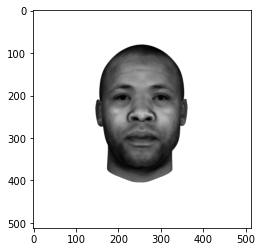

In [12]:
id_ = '021'
img = mpimg.imread(imstart + id_ + imend)
imgplot = plt.imshow(img)
plt.show()

for i in range(0):
    this_id = meta[id_]['pairs']['behavior_similar_hairmatch'][i]
    img = mpimg.imread(imstart + this_id + imend)
    imgplot = plt.imshow(img)
    plt.show()
    
# pairs look good!

In [13]:
def select_oddities(n):
    # just white and black faces, pick a random one
    used = []
    while (len(used) < n/2):
        rand = np.random.choice(list(meta.keys()))
        if (rand not in used and meta[rand]['race_common'] == 'white'):
            used.append(rand)
        
    while (len(used) < n):
        rand = np.random.choice(list(meta.keys()))
        if (rand not in used and meta[rand]['race_common'] in 'black'):
            used.append(rand)
    return used

def get_typical(oddity, used):
    order = ['behavior_group_gender_hairmatch_bin', 'behavior_group_hairmatch_bin', 'behavior_group_gender', 'behavior_group', 'behavior_similar']
    for strat in order:
        pairs = meta[oddity]['pairs'][strat]
        np.random.shuffle(pairs)
        for face in pairs:
            if face not in used:
                return face

def select_typicals(oddities):
    
    out = []
    for odd in oddities:
        out.append(get_typical(odd, oddities + out))
    return out

In [14]:
# SIMULATION
n_exp = 1000
counts = np.zeros(len(list(meta.keys())))

for i in range(n_exp):
    # select 40 random oddities from just black and white faces, 20 each
    oddities = select_oddities(40)
    typicals = select_typicals(oddities)
    
    for typ in typicals:
        counts[int(typ)-1] += 1

[384. 350. 367. 371. 364. 376. 326. 356. 387. 328. 340. 369. 346. 352.
 381. 343. 345. 325. 352. 344. 349. 351. 333. 393. 359. 350. 362. 353.
 325. 362. 386. 334. 350. 336. 385. 363. 364. 367. 391. 363. 351. 366.
 363. 378. 362. 331. 365. 333. 394. 370. 345. 362. 384. 368. 358. 325.
 325. 380. 356. 356. 393. 387. 325. 372. 378. 345. 352. 366. 388. 373.
 338. 329. 349. 386. 337. 350. 373. 338. 344. 337. 349. 377. 331. 326.
 378. 343. 372. 343. 366. 350. 348. 372. 361. 327. 375. 314. 369. 338.
 373. 356. 386. 345. 375. 396. 344. 346. 355. 348. 370. 356. 373. 324.]


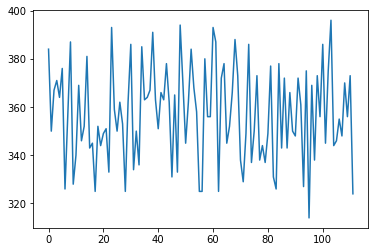

In [15]:
# then, get just the indices of counts that correspond to white and black faces
idx = []
for k in meta.keys():
    if meta[k]['race_common'] in ['white', 'black']:
        idx.append(int(k)-1)
print(counts[idx])
plt.plot(range(len(counts[idx])), counts[idx])
plt.show()

In [16]:
ids = [str(idx+1).zfill(3) for idx, element in enumerate(counts) if 1 < element < 280]
ids

[]

In [17]:
id_ = '102'
print(meta[id_]['pairs']['behavior_group_gender_hairmatch_bin'])
print(meta[id_]['facial_hair'])
for k in meta.keys():
    if meta[k]['race_common'] == meta[id_]['race_common']:
        if meta[k]['gender_common'] == meta[id_]['gender_common']:
            if meta[k]['facial_hair'] == meta[id_]['facial_hair']:
                print(k)
# print(meta[id_]['race_common'])
# print(meta[id_]['gender_common'])
# print(meta[id_]['facial_hair'])
# print(meta[id_]['pairs']['behavior_group_gender_hairmatch'])

['017', '148', '152', '076', '123', '088', '114', '151', '031', '109', '003', '101', '084', '141', '155', '018', '125', '029', '013', '054', '153', '051', '007']
0.0
153
109
152
013
155
141
007
123
051
018
076
102
125
151
017
084
031
003
088
114
148
054
029
101


In [18]:
key_race = {
    'black': 0,
    'white': 1,
    'east_asian': 2,
    'south_asian': 3,
    'latinx': 4,
    'other': 5,
}

In [19]:
proportions = [ 
    [], [], [], [], []
]

for iden in meta.keys():
    curr_race = meta[iden]['race_common']
    curr_prop = info[iden]['race_counts'][key_race[curr_race]] / np.sum(info[iden]['race_counts'])
    
    proportions[key_race[curr_race]].append(curr_prop)

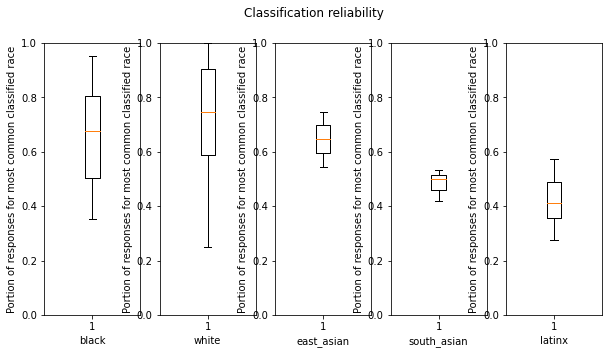

In [20]:
fig, ax = plt.subplots(1,5, figsize = (10,5))
fig.suptitle('Classification reliability')
plt.setp(ax, ylabel = 'Portion of responses for most common classified race', ylim=[0,1])
for i in range(len(ax)):
    ax[i].set_xlabel(key_race2[i])
    ax[i].boxplot(proportions[i])
    

DEMOGRAPHICS AND SUBJECT COUNTS

In [17]:
dempath = datapath + '/demographics/done/'
dem_ignore = pd.read_csv(dempath + 'summarydata_faces_classification_task_02_04_2022.csv')

In [18]:
dem2 = pd.DataFrame()
for file in os.listdir(dempath):
    if 'export' in file:
        dem2 = pd.concat([dem2, pd.read_csv(dempath + file)])

In [19]:
ids = []
for iden in dem2.participant_id.unique():
    if iden in data.subject_id.unique():
        ids.append(iden)
print('N = ' + str(len(ids)))

N = 241


In [61]:
m = 0
w = 0
o = 0

races = []
for iden in ids:
    gender = dem2[dem2.participant_id == iden].Sex.unique()[0]
    if gender == "Male": m+=1
    elif gender == "Female": w+=1
    else: o +=1
        
        
        
print('Gender: men-women-other')
print(m,w,o)
print('Race:')




81 153 7
241


In [21]:
print('Min age: ', min(dem2[dem2.age > 0.0].age))
print('Max age: ', max(dem2[dem2.age > 0.0].age))
print('Median age: ', np.median(dem2[dem2.age > 0.0].age))

Min age:  19.0
Max age:  75.0
Median age:  31.0


In [88]:
currpath = '/Users/chrisiyer/_Current/thesis_folder/face_experiment/results/data/classification/demographics/done/'
dem1 = pd.DataFrame()
for file in os.listdir(currpath):
    dem1 = pd.concat([
        dem1, pd.read_csv(currpath + file)
    ])

In [90]:
exp_test = []
for iden in dem1.experiment_id.unique():
    if iden in data.experiment_id.unique():
        exp_test.append(iden)
print('N = ' + str(len(exp_test)))

N = 216


In [116]:
def get_race(race):
    if race == "['White']":
        return 'w'
    elif race == "['Asian']":
        return 'a'
    elif race == "['Black']":
        return 'b'
    elif race == "['Latinx']":
        return 'l'
    elif race == "['Native']":
        return 'n'
    elif race == "['Other']":
        return 'o'
    elif ',' in race:
        return 'm'
    else:
        print(race)
        print('error')
    
    
    

In [124]:
races = []
test = []
for i in dem1[~pd.isna(dem1.race)].race:
    if i != '[]':
        races.append(get_race(i))

In [146]:
print('white: ', str(races.count('w')/len(races)))
print('black: ', str(races.count('b')/len(races)))
print('asian: ', str(races.count('a')/len(races)))
print('latinx: ', str(races.count('l')/len(races)))
print('native: ', str(races.count('n')/len(races)))
print('multiple: ', str(races.count('m')/len(races)))
print('other: ', str(races.count('o')/len(races)))

white:  0.676
black:  0.04
asian:  0.136
latinx:  0.06
native:  0.004
multiple:  0.076
other:  0.008


In [143]:
len(races)

250